In [1]:
import pandas as pd
import heapq
import matplotlib.pyplot as plt

In [2]:
data = [
    {"ID": 1, "Processing_Time": 3, "Release_Time": 0, "Weight": 5, "Precedence": []},
    {"ID": 2, "Processing_Time": 2, "Release_Time": 1, "Weight": 3, "Precedence": [1]},
    {"ID": 3, "Processing_Time": 1, "Release_Time": 2, "Weight": 4, "Precedence": [1]},
    {"ID": 4, "Processing_Time": 4, "Release_Time": 0, "Weight": 2, "Precedence": []},
    {"ID": 5, "Processing_Time": 2, "Release_Time": 3, "Weight": 1, "Precedence": [2]},
    {"ID": 6, "Processing_Time": 3, "Release_Time": 1, "Weight": 7, "Precedence": [3]},
    {"ID": 7, "Processing_Time": 5, "Release_Time": 0, "Weight": 2, "Precedence": []},
    {"ID": 8, "Processing_Time": 2, "Release_Time": 4, "Weight": 6, "Precedence": [4]},
    {"ID": 9, "Processing_Time": 1, "Release_Time": 5, "Weight": 3, "Precedence": [5]},
    {"ID": 10, "Processing_Time": 2, "Release_Time": 0, "Weight": 2, "Precedence": []},
    {"ID": 11, "Processing_Time": 3, "Release_Time": 1, "Weight": 8, "Precedence": [6]},
    {"ID": 12, "Processing_Time": 4, "Release_Time": 2, "Weight": 2, "Precedence": [7]},
    {"ID": 13, "Processing_Time": 2, "Release_Time": 3, "Weight": 5, "Precedence": [8]},
    {"ID": 14, "Processing_Time": 1, "Release_Time": 4, "Weight": 7, "Precedence": [9]},
    {"ID": 15, "Processing_Time": 3, "Release_Time": 0, "Weight": 6, "Precedence": []}
]

df = pd.DataFrame(data)

display(df)

,ID,Processing_Time,Release_Time,Weight,Precedence
0,1,3,0,5,[]
1,2,2,1,3,[1]
2,3,1,2,4,[1]
3,4,4,0,2,[]
4,5,2,3,1,[2]
5,6,3,1,7,[3]
6,7,5,0,2,[]
7,8,2,4,6,[4]
8,9,1,5,3,[5]
9,10,2,0,2,[]


# 1 Shortest Processing Weighted Time

In [3]:
# Convert precedence constraints to a dictionary for faster lookup
precedence_dict = {row['ID']: set(row['Precedence']) for index, row in df.iterrows()}

# Function to check if all precedence constraints are satisfied
def constraints_satisfied(operation_id, completed_operations):
    return precedence_dict[operation_id].issubset(completed_operations)

# Scheduling function
def schedule_operations(df):
    # Sort operations by Shortest Weighted Processing Time (SWPT)
    df_sorted = df.sort_values(by=['Weight', 'Processing_Time'], ascending=[False, True])
    
    # Initialize the priority queue and completed operations
    pq = []
    completed_operations = set()
    current_time = 0
    schedule = []

    for _, row in df_sorted.iterrows():
        heapq.heappush(pq, (row['Release_Time'], row['ID']))

    while pq:
        release_time, operation_id = heapq.heappop(pq)
        if constraints_satisfied(operation_id, completed_operations):
            processing_time = df[df['ID'] == operation_id]['Processing_Time'].values[0]
            completion_time = current_time + processing_time
            schedule.append((operation_id, current_time, completion_time))
            current_time = completion_time
            completed_operations.add(operation_id)

    return schedule

# Schedule the operations
schedule = schedule_operations(df)
print("Schedule: ", schedule)


Schedule:  [(1, 0, 3), (4, 3, 7), (7, 7, 12), (10, 12, 14), (15, 14, 17), (2, 17, 19), (3, 19, 20), (12, 20, 24), (5, 24, 26), (8, 26, 28), (9, 28, 29)]


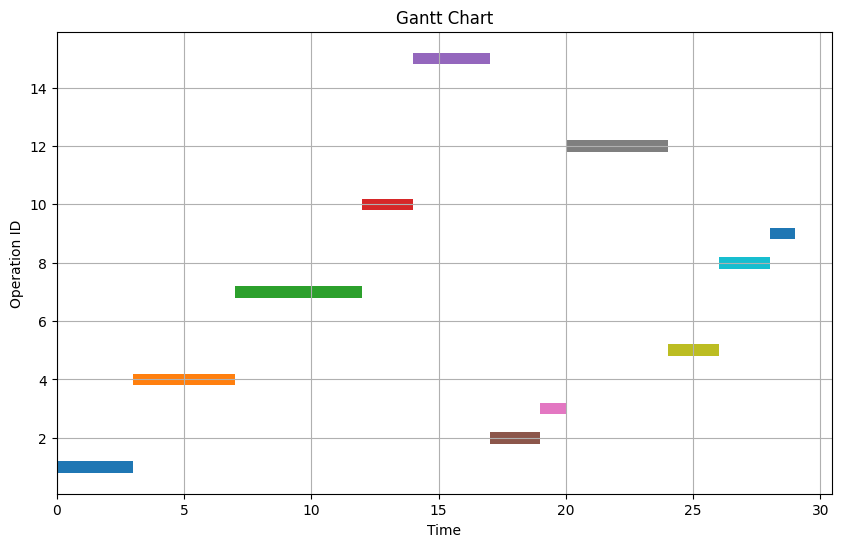

In [4]:
def generate_gantt_chart(schedule):
    fig, ax = plt.subplots(figsize=(10, 6))

    for operation in schedule:
        operation_id, start_time, end_time = operation
        ax.barh(operation_id, end_time - start_time, left=start_time, height=0.4, align='center')

    ax.set_xlabel('Time')
    ax.set_ylabel('Operation ID')
    ax.set_title('Gantt Chart')
    ax.grid(True)

    plt.show()

# Generate Gantt chart for the schedule
generate_gantt_chart(schedule)


# 2 Lagrangian Relaxation

In [5]:
# Initialize Lagrange multipliers for each constraint (arbitrarily starting with 1.0 for simplicity)
multipliers = {row['ID']: 1.0 for index, row in df.iterrows()}

# Function to solve the relaxed problem
def solve_relaxed_problem(df, multipliers):
    df['Adjusted_Weight'] = df.apply(lambda row: row['Weight'] - sum(multipliers[prec] for prec in row['Precedence']), axis=1)
    df_sorted = df.sort_values(by=['Adjusted_Weight', 'Processing_Time'], ascending=[False, True])
    
    schedule = []
    current_time = 0
    completed_operations = set()

    for _, row in df_sorted.iterrows():
        if set(row['Precedence']).issubset(completed_operations):
            schedule.append((row['ID'], current_time, current_time + row['Processing_Time']))
            current_time += row['Processing_Time']
            completed_operations.add(row['ID'])

    return schedule

# Function to update Lagrange multipliers
def update_multipliers(multipliers, schedule, step_size=0.1):
    for op in schedule:
        op_id = op[0]
        for prec in df[df['ID'] == op_id]['Precedence'].values[0]:
            multipliers[prec] += step_size
    return multipliers

# Lagrangian relaxation method
def lagrangian_relaxation(df, max_iter=100, tolerance=1e-4):
    global multipliers
    prev_schedule = None
    
    for _ in range(max_iter):
        schedule = solve_relaxed_problem(df, multipliers)
        
        if prev_schedule and schedule == prev_schedule:
            break
        
        multipliers = update_multipliers(multipliers, schedule)
        prev_schedule = schedule

    return schedule

# Schedule the operations using Lagrangian relaxation
schedule = lagrangian_relaxation(df)
print("Schedule: ", schedule)


Schedule:  [(15, 0, 3), (1, 3, 6), (3, 6, 7), (10, 7, 9), (4, 9, 13), (7, 13, 18), (2, 18, 20), (12, 20, 24), (5, 24, 26)]


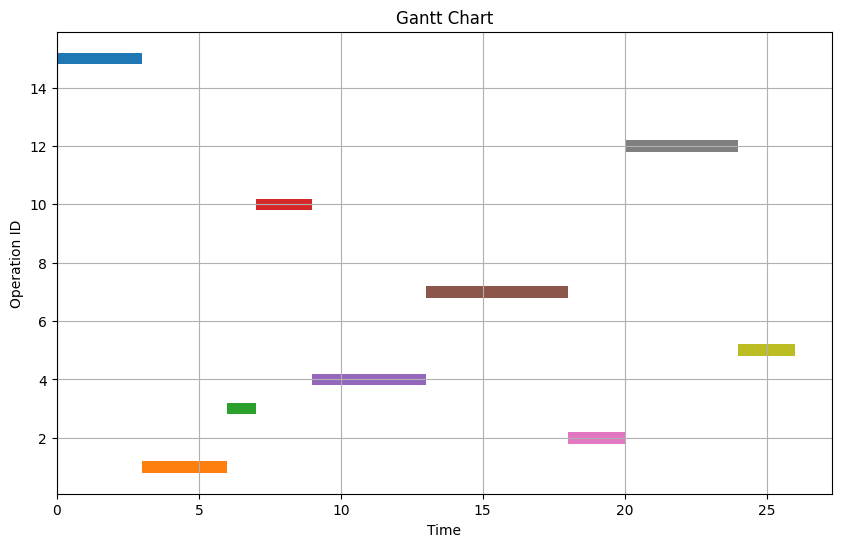

In [6]:
generate_gantt_chart(schedule)
